# Práctica 2

In [1]:
# Importación de módulos necesarios
using DataFrames
using CSV
using Statistics
using Random
using HypothesisTests
using StatsBase
using Plots
using MLJ, MLJBase, MLJModels, MLJModelInterface
using CategoricalArrays
using LinearAlgebra
using Printf

# Configuración de semilla para reproducibilidad
const SEED = 104
Random.seed!(SEED)

println("Paquetes cargados correctamente")

Paquetes cargados correctamente


## PARTE 1: PREPARACIÓN DE LOS DATOS

### 1.1 Carga y unificación de datos

In [2]:
# Función recursiva para encontrar todos los CSV
function all_csv_files(dir::String)
    archivos = String[]
    for entry in readdir(dir; join=true)
        if isdir(entry) # si es un directorio, llamar recursivamente
            append!(archivos, all_csv_files(entry)) 
        elseif endswith(entry, ".csv") # si es un archivo CSV
            push!(archivos, entry)
        end
    end
    return archivos
end

function import_dataset()
    base_path = joinpath(pwd(), "Datos_Práctica_Evaluación")

    # Obtener todos los archivos CSV recursivamente
    rutas = all_csv_files(base_path)
    println("Archivos CSV encontrados: ", length(rutas))
    
    if isempty(rutas)
        error("No se encontraron archivos CSV en la estructura de carpetas.")
    end
    
    # Leer y combinar todos los CSV
    dfs = DataFrame[]
    for (i, ruta) in enumerate(rutas)
        println("  [$i/$(length(rutas))] Leyendo: ", basename(ruta))
        df_temp = CSV.read(ruta, DataFrame)
        push!(dfs, df_temp)
    end

    # Concatenar todos los DataFrames
    df_unificado = vcat(dfs...)
    println("Dimensiones del DataFrame unificado: ", size(df_unificado))
    return df_unificado
end

println("\n" * "-"^80)
println("CARGA Y UNIFICACIÓN DE DATOS")
println("-"^80)

# Importar el dataset unificado
df = import_dataset()



--------------------------------------------------------------------------------
CARGA Y UNIFICACIÓN DE DATOS
--------------------------------------------------------------------------------
Archivos CSV encontrados: 30
  [1/30] Leyendo: Sujeto_01.csv
  [2/30] Leyendo: Sujeto_05.csv
  [3/30] Leyendo: Sujeto_07.csv
  [4/30] Leyendo: Sujeto_11.csv
  [5/30] Leyendo: Sujeto_03.csv
  [6/30] Leyendo: Sujeto_09.csv
  [7/30] Leyendo: Sujeto_23.csv
  [8/30] Leyendo: Sujeto_25.csv
  [9/30] Leyendo: Sujeto_15.csv
  [10/30] Leyendo: Sujeto_17.csv
  [11/30] Leyendo: Sujeto_21.csv
  [12/30] Leyendo: Sujeto_13.csv
  [13/30] Leyendo: Sujeto_19.csv
  [14/30] Leyendo: Sujeto_27.csv
  [15/30] Leyendo: Sujeto_29.csv
  [16/30] Leyendo: Sujeto_02.csv
  [17/30] Leyendo: Sujeto_04.csv
  [18/30] Leyendo: Sujeto_06.csv
  [19/30] Leyendo: Sujeto_08.csv
  [20/30] Leyendo: Sujeto_10.csv
  [21/30] Leyendo: Sujeto_12.csv
  [22/30] Leyendo: Sujeto_14.csv
  [23/30] Leyendo: Sujeto_16.csv
  [24/30] Leyendo: Sujeto_18.

Row,subject,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,⋯
,Int64,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64?,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64?,Float64?,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64?,Float64,Float64,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64?,Float64?,Float64?,Float64,⋯
1,1,0.288585,-0.0202942,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.94322,-0.407747,-0.679338,missing,0.929294,-0.853011,0.35991,-0.0585264,0.256892,-0.224848,0.264106,-0.0952456,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.66079,0.963396,-0.14084,0.115375,-0.98525,-0.981708,-0.877625,-0.985001,-0.984416,-0.894677,0.892055,-0.161265,0.12466,0.977436,-0.123213,0.0564827,-0.375426,0.899469,-0.970905,-0.97551,-0.984325,-0.988849,-0.917743,-1.0,-1.0,0.113806,-0.590425,0.591146,missing,0.592469,-0.745449,0.720862,-0.712372,0.7113,-0.995112,0.995675,-0.995668,0.991653,0.570222,0.439027,0.986913,0.0779963,0.0050008,-0.0678308,-0.993519,-0.98836,-0.993575,-0.994488,-0.986207,-0.992818,-0.98518,-0.991994,-0.993119,0.989835,0.991957,0.990519,-0.993522,-0.999935,-0.99982,-0.999878,⋯
2,1,0.274262,-0.012

In [3]:
println("\n" * "-"^80)
println("DESCRIPCIÓN DEL DATASET")
println("-"^80)

# Número de variables (columnas)
num_variables = ncol(df)
println("• Número de variables: ", num_variables)

# Número de instancias (filas)
num_instancias = nrow(df)
println("• Número de instancias: ", num_instancias)

# Número de individuos únicos (columna 'subject')
num_individuos = length(unique(df.subject))
println("• Número de individuos: ", num_individuos)

# Columna de salida: la última columna
num_clases_salida = length(unique(df.Activity))
println("• Número de clases de salida: ", num_clases_salida)

clases = unique(df.Activity)
println("• Clases de salida (activity): ", clases)



--------------------------------------------------------------------------------
DESCRIPCIÓN DEL DATASET
--------------------------------------------------------------------------------
• Número de variables: 563
• Número de instancias: 10299
• Número de individuos: 30
• Número de clases de salida: 6
• Clases de salida (activity): String31["STANDING", "SITTING", "LAYING", "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"]


### 1.2 Análisis de valores ausentes

In [4]:
function missing_values_summary(df::DataFrame)   
    # Lista de columnas con missing
    columnas_con_missing = String[]
    missing_counts = Dict{String, Int}()
    
    println("\nColumnas con valores ausentes:")
    for col in names(df)
        num_missing = count(ismissing, df[!, col])
        if num_missing > 0
            push!(columnas_con_missing, col)
            missing_counts[col] = num_missing
            pct_missing = num_missing / nrow(df) * 100
            println("  • $(col): $(num_missing) valores ($(round(pct_missing, digits=2))%)")
        end
    end
    
    if isempty(columnas_con_missing)
        println("    No hay columnas con valores ausentes.")
    else
        println("\n  Total de columnas con valores ausentes: ", length(columnas_con_missing))
    end
    
    # Porcentaje de valores ausentes en todo el dataset
    total_missing = count(ismissing, Iterators.flatten(eachcol(df)))
    total_values = nrow(df) * ncol(df)
    pct_total_missing = total_missing / total_values * 100
    println("\n  Porcentaje total de valores ausentes: $(round(pct_total_missing, digits=4))%")
    
    return columnas_con_missing, missing_counts
end

println("\n" * "-"^80)
println("ANÁLISIS DE VALORES AUSENTES")
println("-"^80)
columnas_missing, missing_counts = missing_values_summary(df);


--------------------------------------------------------------------------------
ANÁLISIS DE VALORES AUSENTES
--------------------------------------------------------------------------------

Columnas con valores ausentes:
  • tBodyAcc-std()-X: 2 valores (0.02%)
  • tBodyAcc-std()-Z: 2 valores (0.02%)
  • tBodyAcc-mad()-X: 2 valores (0.02%)
  • tBodyAcc-mad()-Y: 3 valores (0.03%)
  • tBodyAcc-mad()-Z: 3 valores (0.03%)
  • tBodyAcc-max()-X: 2 valores (0.02%)
  • tBodyAcc-max()-Z: 1 valores (0.01%)
  • tBodyAcc-sma(): 1 valores (0.01%)
  • tBodyAcc-iqr()-X: 3 valores (0.03%)
  • tBodyAcc-iqr()-Y: 1 valores (0.01%)
  • tBodyAcc-entropy()-Z: 1029 valores (9.99%)
  • tBodyAcc-arCoeff()-Z,2: 1029 valores (9.99%)
  • tBodyAcc-correlation()-X,Y: 1029 valores (9.99%)
  • tGravityAcc-std()-Y: 1029 valores (9.99%)
  • tGravityAcc-std()-Z: 1029 valores (9.99%)
  • tGravityAcc-mad()-Z: 1029 valores (9.99%)
  • tGravityAcc-max()-X: 1029 valores (9.99%)
  • tGravityAcc-arCoeff()-X,3: 1029 valores (

### 1.3  Tratamiento y transformación de datos

Mediana por sujeto (subject-wise).
Los datos son MCAR y cada sujeto tiene características únicas.

In [5]:
function subject_wise_mean_imputation(df::DataFrame)
    df_imputed = deepcopy(df)
    subject_col = :subject
    
    # Obtener columnas numéricas con missing
    num_cols = String[]
    for col in names(df)
        if col != string(subject_col) && col != "Activity" && any(ismissing, df[!, col])
            push!(num_cols, col)
        end
    end
    
    println("  Columnas numéricas a imputar: ", length(num_cols))
    
    # Contadores para estadísticas
    total_imputed = 0
    
    for subj in unique(df[!, subject_col])
        idx = findall(==(subj), df[!, subject_col])
        subdf = df[idx, :]
        
        for col in num_cols
            # Contar valores missing en esta columna para este sujeto
            missing_mask = ismissing.(subdf[!, col])
            n_missing = sum(missing_mask)
            
            if n_missing == 0
                continue
            end
            
            # Si todos los valores del sujeto son missing, usar la mediana global
            if all(missing_mask)
                # Media global (de todos los sujetos que tienen valores)
                global_median = median(skipmissing(df[!, col]))
                df_imputed[idx, col] .= global_median
                total_imputed += n_missing
            else
                # Calcular la mediana del sujeto
                subject_median = median(skipmissing(subdf[!, col]))
                # Reemplazar missing por la mediana del sujeto
                df_imputed[idx, col] = coalesce.(df_imputed[idx, col], subject_median)
                total_imputed += n_missing
            end
        end
    end
    
    println("  Valores imputados: ", total_imputed)
    return df_imputed
end

println("\n" * "-"^80)
println("TRATAMIENTO Y TRANSFORMACIÓN DE DATOS")
println("-"^80)

df_imputed = subject_wise_mean_imputation(df)

# Comprobar que no quedan valores ausentes
println("\n  Verificación post-imputación:")
remaining_missing = count(ismissing, Iterators.flatten(eachcol(df_imputed)))
println("  Valores ausentes restantes: ", remaining_missing)
@assert remaining_missing == 0 "Existen valores ausentes"


--------------------------------------------------------------------------------
TRATAMIENTO Y TRANSFORMACIÓN DE DATOS
--------------------------------------------------------------------------------
  Columnas numéricas a imputar: 175
  Valores imputados: 57892

  Verificación post-imputación:
  Valores ausentes restantes: 0


### Separación de datos: X (features), y (target), subject_id

Separa el dataset en:
- X: Matriz de características (Float64)
- y: Vector categórico de etiquetas (CategoricalArray)
- subject_id: Vector de IDs de sujetos


NO se usa one-hot encoding. MLJ trabaja mejor con CategoricalArray

In [7]:
function separate_data(df::DataFrame)
    # 1. Separar el ID del sujeto
    subject_id = df[!, :subject]
    
    # 2. Separar y (Variable Objetivo)
    # Convertir Activity a categórico
    y = categorical(df[!, :Activity])
    
    # 3. Separar X (Features)
    # Seleccionar solo columnas numéricas (excluir subject y Activity)
    X_df = DataFrames.select(df, Not([:subject, :Activity]))
    
    # Convertir DataFrame a Matrix para eficiencia
    # MLJ puede trabajar con ambos, pero Matrix es más eficiente para operaciones numéricas
    X_matrix = Matrix{Float64}(X_df)
    
    return X_matrix, y, subject_id
end

println("\n" * "-"^80)
println("SEPARACIÓN DE DATOS")
println("-"^80)

X_full, y_full, subject_id_full = separate_data(df_imputed)
println("\nDatos separados:")
println(" • X (features): $(size(X_full)) - Tipo: $(typeof(X_full))")
println(" • y (target): $(size(y_full)) - Tipo: $(typeof(y_full))")
println(" • subject_id: $(size(subject_id_full))")



--------------------------------------------------------------------------------
SEPARACIÓN DE DATOS
--------------------------------------------------------------------------------

Datos separados:
 • X (features): (10299, 561) - Tipo: Matrix{Float64}
 • y (target): (10299,) - Tipo: CategoricalVector{String31, UInt32, String31, CategoricalValue{String31, UInt32}, Union{}}
 • subject_id: (10299,)


### 1.4 Partición Holdout (subject-wise)

Realiza la partición holdout asegurando que todos los datos de un sujeto están en el mismo conjunto (train o test).

In [8]:
function holdout_split_subject_wise(X::Matrix, y::CategoricalArray, subject_id::AbstractArray; 
                                    test_ratio::Real=0.1)

    # Asegurar reproducibilidad
    Random.seed!(SEED) 
    
    unique_subjects = unique(subject_id)
    num_subjects = length(unique_subjects)
    
    # Seleccionar el 10% de sujetos para test
    n_test = max(1, Int(round(num_subjects * test_ratio)))
    shuffled_subjects = shuffle(unique_subjects)
    test_subjects = shuffled_subjects[1:n_test]
    println("  Individuos seleccionados para TEST (holdout $(round(test_ratio*100))%): ", sort(test_subjects))

    # División de instancias
    is_test = [s in test_subjects for s in subject_id]
    is_train = .!is_test
    
    X_train = X[is_train, :]
    y_train = y[is_train]
    subject_train = subject_id[is_train]
    
    X_test = X[is_test, :]
    y_test = y[is_test]
    subject_test = subject_id[is_test]

    println("\n  Partición Holdout completada:")
    println("  • TRAIN: $(size(X_train, 1)) instancias ($(length(unique(subject_train))) sujetos)")
    println("  • TEST: $(size(X_test, 1)) instancias ($(length(unique(subject_test))) sujetos)")

    # Verificar distribución de clases
    println("\n  Distribución de clases en TRAIN:")
    for (clase, count) in sort(collect(countmap(y_train)))
        pct = count / length(y_train) * 100
        println("    • $clase: $count ($(round(pct, digits=1))%)")
    end
    
    println("\n  Distribución de clases en TEST:")
    for (clase, count) in sort(collect(countmap(y_test)))
        pct = count / length(y_test) * 100
        println("    • $clase: $count ($(round(pct, digits=1))%)")
    end

    return X_train, y_train, subject_train, X_test, y_test, subject_test
end

println("\n" * "-"^80)
println("PARTICIÓN HOLDOUT (10% TEST)")
println("-"^80)
X_train, y_train, subject_train, X_test, y_test, subject_test = holdout_split_subject_wise(X_full, y_full, subject_id_full);




--------------------------------------------------------------------------------
PARTICIÓN HOLDOUT (10% TEST)
--------------------------------------------------------------------------------
  Individuos seleccionados para TEST (holdout 10.0%): [18, 22, 25]

  Partición Holdout completada:
  • TRAIN: 9205 instancias (27 sujetos)
  • TEST: 1094 instancias (3 sujetos)

  Distribución de clases en TRAIN:
    • LAYING: 1734 (18.8%)
    • SITTING: 1593 (17.3%)
    • STANDING: 1696 (18.4%)
    • WALKING: 1546 (16.8%)
    • WALKING_DOWNSTAIRS: 1257 (13.7%)
    • WALKING_UPSTAIRS: 1379 (15.0%)

  Distribución de clases en TEST:
    • LAYING: 210 (19.2%)
    • SITTING: 184 (16.8%)
    • STANDING: 210 (19.2%)
    • WALKING: 176 (16.1%)
    • WALKING_DOWNSTAIRS: 149 (13.6%)
    • WALKING_UPSTAIRS: 165 (15.1%)


### 1.5  Validación cruzada individual-wise 

Crea k particiones para validación cruzada asegurando que todos los datos de un sujeto están en el mismo fold.


In [9]:
function individualwise_cv_splits(subject_id::AbstractVector; k=5)
    Random.seed!(SEED)
    
    subjects = unique(subject_id)
    n = length(subjects)
    shuffled = shuffle(subjects)

    # Dividir sujetos en k folds equilibrados
    folds = [shuffled[floor(Int, (i-1)*n/k)+1 : floor(Int, i*n/k)] for i in 1:k]

    splits = Vector{NamedTuple{(:train,:test),Tuple{Vector{Int},Vector{Int}}}}(undef, k)
    
    println("\nFOLD | Train (muestras) | Val (muestras) | Train sujetos | Val sujetos")
    println("----------------------------------------------------------------------")

    for i in 1:k
        val_subjects = folds[i]
        train_subjects = vcat(folds[1:i-1]..., folds[i+1:end]...)
        
        train_idx = findall(s -> s in train_subjects, subject_id)
        val_idx   = findall(s -> s in val_subjects, subject_id)
        
        splits[i] = (train=train_idx, test=val_idx)
        
        @printf("  %d  |       %4d       |      %4d      |       %2d      |     %2d\n",
                i, length(train_idx), length(val_idx), length(train_subjects), length(val_subjects))
    end

    return splits
end

cv_splits = individualwise_cv_splits(subject_train; k=5);



FOLD | Train (muestras) | Val (muestras) | Train sujetos | Val sujetos
----------------------------------------------------------------------
  1  |       7378       |      1827      |       22      |      5
  2  |       7565       |      1640      |       22      |      5
  3  |       7103       |      2102      |       21      |      6
  4  |       7503       |      1702      |       22      |      5
  5  |       7271       |      1934      |       21      |      6


### 1.6 Normalización

In [10]:
println("\n" * "-"^80)
println("NORMALIZACIÓN")
println("-"^80)

mutable struct MinMaxNormalizer <: Unsupervised end

function MLJBase.fit(normalizer::MinMaxNormalizer, verbosity::Int, X)
    X_matrix = MLJBase.matrix(X)
    
    # Calcular min y max por columna
    feature_min = vec(minimum(X_matrix, dims=1))
    feature_max = vec(maximum(X_matrix, dims=1))
    
    fitresult = (feature_min=feature_min, feature_max=feature_max)
    cache = nothing
    report = (feature_ranges = feature_max .- feature_min,)
    
    return fitresult, cache, report
end

function MLJBase.transform(normalizer::MinMaxNormalizer, fitresult, X)
    X_matrix = MLJBase.matrix(X)
    
    feature_min = fitresult.feature_min
    feature_max = fitresult.feature_max
    
    # Normalización Min-Max
    X_normalized = similar(X_matrix, Float64)
    
    for j in 1:size(X_matrix, 2)
        min_j = feature_min[j]
        range_j = feature_max[j] - min_j
        
        if range_j ≈ 0.0
            X_normalized[:, j] .= 0.0
        else
            X_normalized[:, j] = (X_matrix[:, j] .- min_j) ./ range_j
        end
    end
    
    return MLJBase.table(X_normalized)
end

# Registrar el transformador en MLJ
MLJBase.input_scitype(::Type{<:MinMaxNormalizer}) = MLJBase.Table(MLJBase.Continuous)
MLJBase.output_scitype(::Type{<:MinMaxNormalizer}) = MLJBase.Table(MLJBase.Continuous)

println("\nMinMaxNormalizer registrado en MLJ: ", MinMaxNormalizer())


--------------------------------------------------------------------------------
NORMALIZACIÓN
--------------------------------------------------------------------------------

MinMaxNormalizer registrado en MLJ: MinMaxNormalizer()


## PARTE 2: Modelos básicos y selección de atributos

### 2.1 Filtrado de características
- Filtrado ANOVA
- Filtrado de Pearson
- Filtrado de Spearman
- Filtrado de Kendall Tau
- Filtrado por Mutual Information
- Filtrado RFE (con Logistic Regression, eliminando el 50 % de las variables 
en cada iteración)


Filtrado ANOVA

In [11]:
mutable struct ANOVAFilter <: MLJModelInterface.Supervised
    k::Int
end
ANOVAFilter(; k::Int=50) = ANOVAFilter(k)

function MLJModelInterface.fit(model::ANOVAFilter, verbosity::Int, X, y)
    Xmat = Float64.(MLJBase.matrix(X))
    y_numeric = y isa CategoricalVector ? Int.(levelcode.(y)) : Int.(y)
    
    n_features = size(Xmat, 2)
    fstats = zeros(Float64, n_features)
    
    for j in 1:n_features
        feature = Xmat[:, j]
        classes = unique(y_numeric)
        groups = [feature[y_numeric .== c] for c in classes]
        groups = filter(g -> length(g) > 0, groups)
        
        if length(groups) >= 2
            try
                test = OneWayANOVATest(groups...)
                MSt = test.SStᵢ / test.DFt
                MSe = test.SSeᵢ / test.DFe
                fstats[j] = MSe > 0 ? MSt / MSe : 0.0
            catch
                fstats[j] = 0.0
            end
        end
    end
    
    k_actual = min(model.k, n_features)
    idxs = sortperm(fstats, rev=true)[1:k_actual]
    feature_names = collect(Tables.columnnames(X))
    selected_names = [feature_names[i] for i in idxs]
    
    fitresult = (idxs=idxs, selected_names=selected_names)
    report = (fstats=fstats, selected_indices=idxs, selected_features=selected_names)
    
    return fitresult, nothing, report
end

function MLJModelInterface.transform(model::ANOVAFilter, fitresult, X)
    Xmat = MLJBase.matrix(X)
    X_selected = Xmat[:, fitresult.idxs]
    return MLJBase.table(X_selected, names=fitresult.selected_names)
end

MLJModelInterface.input_scitype(::Type{<:ANOVAFilter}) = Table(Continuous)
MLJModelInterface.target_scitype(::Type{<:ANOVAFilter}) = AbstractVector{<:Finite}
MLJModelInterface.output_scitype(::Type{<:ANOVAFilter}) = Table(Continuous)

println("\nANOVAFilter registrado en MLJ: ", ANOVAFilter())


ANOVAFilter registrado en MLJ: ANOVAFilter(k = 50)


Filtrado de Pearson

In [12]:
mutable struct PearsonCorrelationFilter <: MLJModelInterface.Supervised
    k::Int
end

PearsonCorrelationFilter(; k::Int=50) = PearsonCorrelationFilter(k)

function MLJModelInterface.fit(model::PearsonCorrelationFilter, verbosity::Int, X, y)
    Xmat = Float64.(MLJBase.matrix(X))
    y_numeric = y isa CategoricalVector ? Float64.(levelcode.(y)) : Float64.(y)
    
    n_features = size(Xmat, 2)
    scores = zeros(Float64, n_features)
    
    for j in 1:n_features
        try
            scores[j] = abs(cor(Xmat[:, j], y_numeric))
        catch
            scores[j] = 0.0
        end
    end
    
    k_actual = min(model.k, n_features)
    idxs = sortperm(scores, rev=true)[1:k_actual]
    feature_names = collect(Tables.columnnames(X))
    selected_names = [feature_names[i] for i in idxs]
    
    fitresult = (idxs=idxs, selected_names=selected_names)
    report = (scores=scores, selected_indices=idxs, selected_features=selected_names)
    
    return fitresult, nothing, report
end

function MLJModelInterface.transform(model::PearsonCorrelationFilter, fitresult, X)
    Xmat = MLJBase.matrix(X)
    X_selected = Xmat[:, fitresult.idxs]
    return MLJBase.table(X_selected, names=fitresult.selected_names)
end

MLJModelInterface.input_scitype(::Type{<:PearsonCorrelationFilter}) = Table(Continuous)
MLJModelInterface.target_scitype(::Type{<:PearsonCorrelationFilter}) = AbstractVector{<:Finite}
MLJModelInterface.output_scitype(::Type{<:PearsonCorrelationFilter}) = Table(Continuous)

println("\nPearsonCorrelationFilter registrado en MLJ: ", PearsonCorrelationFilter())


PearsonCorrelationFilter registrado en MLJ: PearsonCorrelationFilter(k = 50)


Filtrado de Spearman

In [13]:
mutable struct SpearmanCorrelationFilter <: MLJModelInterface.Supervised
    k::Int
end

SpearmanCorrelationFilter(; k::Int=50) = SpearmanCorrelationFilter(k)

function MLJModelInterface.fit(model::SpearmanCorrelationFilter, verbosity::Int, X, y)
    Xmat = Float64.(MLJBase.matrix(X))
    y_numeric = y isa CategoricalVector ? Float64.(levelcode.(y)) : Float64.(y)
    
    n_features = size(Xmat, 2)
    scores = zeros(Float64, n_features)
    
    for j in 1:n_features
        try
            scores[j] = abs(corspearman(Xmat[:, j], y_numeric))
        catch
            scores[j] = 0.0
        end
    end
    
    k_actual = min(model.k, n_features)
    idxs = sortperm(scores, rev=true)[1:k_actual]
    feature_names = collect(Tables.columnnames(X))
    selected_names = [feature_names[i] for i in idxs]
    
    fitresult = (idxs=idxs, selected_names=selected_names)
    report = (scores=scores, selected_indices=idxs, selected_features=selected_names)
    
    return fitresult, nothing, report
end

function MLJModelInterface.transform(model::SpearmanCorrelationFilter, fitresult, X)
    Xmat = MLJBase.matrix(X)
    X_selected = Xmat[:, fitresult.idxs]
    return MLJBase.table(X_selected, names=fitresult.selected_names)
end

MLJModelInterface.input_scitype(::Type{<:SpearmanCorrelationFilter}) = Table(Continuous)
MLJModelInterface.target_scitype(::Type{<:SpearmanCorrelationFilter}) = AbstractVector{<:Finite}
MLJModelInterface.output_scitype(::Type{<:SpearmanCorrelationFilter}) = Table(Continuous)

println("\nSpearmanCorrelationFilter registrado en MLJ: ", SpearmanCorrelationFilter())


SpearmanCorrelationFilter registrado en MLJ: SpearmanCorrelationFilter(k = 50)


Filtrado de Kendall Tau 

In [14]:
mutable struct KendallCorrelationFilter <: MLJModelInterface.Supervised
    k::Int
end

KendallCorrelationFilter(; k::Int=50) = KendallCorrelationFilter(k)
function MLJModelInterface.fit(model::KendallCorrelationFilter, verbosity::Int, X, y)
    Xmat = Float64.(MLJBase.matrix(X))
    y_numeric = y isa CategoricalVector ? Float64.(levelcode.(y)) : Float64.(y)
    
    n_features = size(Xmat, 2)
    scores = zeros(Float64, n_features)
    
    for j in 1:n_features
        try
            scores[j] = abs(corkendall(Xmat[:, j], y_numeric))
        catch
            scores[j] = 0.0
        end
    end
    
    k_actual = min(model.k, n_features)
    idxs = sortperm(scores, rev=true)[1:k_actual]
    feature_names = collect(Tables.columnnames(X))
    selected_names = [feature_names[i] for i in idxs]
    
    fitresult = (idxs=idxs, selected_names=selected_names)
    report = (scores=scores, selected_indices=idxs, selected_features=selected_names)
    
    return fitresult, nothing, report
end

function MLJModelInterface.transform(model::KendallCorrelationFilter, fitresult, X)
    Xmat = MLJBase.matrix(X)
    X_selected = Xmat[:, fitresult.idxs]
    return MLJBase.table(X_selected, names=fitresult.selected_names)
end

MLJModelInterface.input_scitype(::Type{<:KendallCorrelationFilter}) = Table(Continuous)
MLJModelInterface.target_scitype(::Type{<:KendallCorrelationFilter}) = AbstractVector{<:Finite}
MLJModelInterface.output_scitype(::Type{<:KendallCorrelationFilter}) = Table(Continuous)

println("\nKendallCorrelationFilter registrado en MLJ: ", KendallCorrelationFilter())


KendallCorrelationFilter registrado en MLJ: KendallCorrelationFilter(k = 50)


Filtrado por Mutual Information

In [15]:
mutable struct MutualInformationFilter <: Supervised
    k::Int
    n_bins::Int
end

MutualInformationFilter(; k::Int=50, n_bins::Int=10) = MutualInformationFilter(k, n_bins)

function discrete_entropy(x::Vector)
    counts = countmap(x)
    probs = collect(values(counts)) ./ length(x)
    return -sum(p * log2(p) for p in probs if p > 0)
end

function mutual_information_score(x::Vector{Float64}, y::Vector{Int}; n_bins::Int=10)
    # Discretizar x
    x_min, x_max = extrema(x)
    if x_max ≈ x_min
        return 0.0
    end
    
    bin_edges = range(x_min, x_max, length=n_bins+1)
    x_discrete = [searchsortedfirst(bin_edges, val) - 1 for val in x]
    x_discrete = clamp.(x_discrete, 1, n_bins)
    
    # Calcular entropías
    H_x = discrete_entropy(x_discrete)
    H_y = discrete_entropy(y)
    
    # Entropía conjunta
    joint_counts = countmap(collect(zip(x_discrete, y)))
    joint_probs = collect(values(joint_counts)) ./ length(x)
    H_xy = -sum(p * log2(p) for p in joint_probs if p > 0)
    
    # Información mutua
    return H_x + H_y - H_xy
end

function MLJModelInterface.fit(model::MutualInformationFilter, verbosity::Int, X, y)
    Xmat = Float64.(MLJBase.matrix(X))
    y_numeric = Int.(levelcode.(y))
    
    n_features = size(Xmat, 2)
    mi_scores = zeros(Float64, n_features)
    
    for j in 1:n_features
        try
            mi_scores[j] = mutual_information_score(Xmat[:, j], y_numeric; n_bins=model.n_bins)
        catch
            mi_scores[j] = 0.0
        end
    end
    
    k_actual = min(model.k, n_features)
    idxs = sortperm(mi_scores, rev=true)[1:k_actual]
    feature_names = collect(Tables.columnnames(X))
    selected_names = [feature_names[i] for i in idxs]
    
    fitresult = (idxs=idxs, selected_names=selected_names)
    report = (mi_scores=mi_scores, selected_indices=idxs, selected_features=selected_names)

    
    return fitresult, nothing, report
end

function MLJModelInterface.transform(model::MutualInformationFilter, fitresult, X)
    Xmat = MLJBase.matrix(X)
    X_selected = Xmat[:, fitresult.idxs]
    return MLJBase.table(X_selected, names=fitresult.selected_names)
end

MLJModelInterface.input_scitype(::Type{<:MutualInformationFilter}) = Table(Continuous)
MLJModelInterface.target_scitype(::Type{<:MutualInformationFilter}) = AbstractVector{<:Finite}
MLJModelInterface.output_scitype(::Type{<:MutualInformationFilter}) = Table(Continuous)

println("\nMutualInformationFilter registrado en MLJ: ", MutualInformationFilter())


MutualInformationFilter registrado en MLJ: MutualInformationFilter(k = 50, …)


Filtrado RFE

In [16]:
using MLJ
using MLJLinearModels
using Tables

# Cargar LogisticClassifier
LogisticClassifier = @load LogisticClassifier pkg=MLJLinearModels verbosity=0

# Definición del RFEFilter
mutable struct RFEFilter <: MLJModelInterface.Supervised
    k::Int
    step::Float64  # Porcentaje a eliminar en cada iteración (0.5 = 50%)
end
RFEFilter(; k::Int=50, step::Float64=0.5) = RFEFilter(k, step)

# Fit de RFEFilter
function MLJModelInterface.fit(model::RFEFilter, verbosity::Int, X, y)
    Xmat = Float64.(MLJBase.matrix(X))
    feature_names = collect(Tables.columnnames(X))
    n_features = size(Xmat, 2)
    
    current_features = collect(1:n_features)
    
    while length(current_features) > model.k
        importances = ones(length(current_features))  # <- siempre definida
        
        # Entrenar modelo con features actuales
        X_subset = Xmat[:, current_features]
        X_table = MLJBase.table(X_subset)
        
        clf = LogisticClassifier()      # sin verbosity
        mach = machine(clf, X_table, y)
        fit!(mach; verbosity=0)         # sin verbosity
        
        # Obtener importancias (coeficientes)
        try
            fitted = fitted_params(mach)
            if haskey(fitted, :coefs)
                coefs = fitted.coefs
                if coefs isa Matrix
                    importances = vec(sum(abs.(coefs), dims=1))
                else
                    importances = abs.(coefs)
                end
            end
        catch
            # Si falla, importances ya está inicializada
        end
        
        # Número de features a mantener
        n_to_keep = max(model.k, round(Int, length(current_features) * (1 - model.step)))
        
        # Seleccionar mejores features
        keep_indices = sortperm(importances, rev=true)[1:n_to_keep]
        current_features = current_features[keep_indices]
        
        if verbosity > 0
            println("  RFE: $(length(current_features)) features restantes")
        end
    end
    
    selected_names = [feature_names[i] for i in current_features]
    
    fitresult = (idxs=current_features, selected_names=selected_names)
    report = (selected_indices=current_features, selected_features=selected_names)
    
    return fitresult, nothing, report
end

# Transform de RFEFilter
function MLJModelInterface.transform(model::RFEFilter, fitresult, X)
    Xmat = MLJBase.matrix(X)
    X_selected = Xmat[:, fitresult.idxs]
    return MLJBase.table(X_selected, names=fitresult.selected_names)
end

# Definición de scitypes
MLJModelInterface.input_scitype(::Type{<:RFEFilter}) = Table(Continuous)
MLJModelInterface.target_scitype(::Type{<:RFEFilter}) = AbstractVector{<:Finite}
MLJModelInterface.output_scitype(::Type{<:RFEFilter}) = Table(Continuous)

println("\nRFEFilter registrado en MLJ: ", RFEFilter())



RFEFilter registrado en MLJ: RFEFilter(k = 50, …)


In [17]:
# Verificar tipos y dimensiones
println("-"^80)
println("VERIFICACIÓN DE DATOS CARGADOS")
println("-"^80)

println("\n X_train:")
println("  • Tipo: ", typeof(X_train))
println("  • Dimensiones: ", size(X_train))
println("  • Elemento tipo: ", eltype(X_train))

println("\n y_train:")
println("  • Tipo: ", typeof(y_train))
println("  • Longitud: ", length(y_train))
println("  • Clases únicas: ", levels(y_train))
println("  • Distribución: ")
for (clase, count) in sort(collect(countmap(y_train)))
    pct = count / length(y_train) * 100
    println("    • $clase: $count ($(round(pct, digits=1))%)")
end

println("\n X_test:")
println("  • Dimensiones: ", size(X_test))

println("\n📊 y_test:")
println("  • Longitud: ", length(y_test))

println("\n📊 CV Splits:")
println("  • Número de folds: ", length(cv_splits))


--------------------------------------------------------------------------------
VERIFICACIÓN DE DATOS CARGADOS
--------------------------------------------------------------------------------

 X_train:
  • Tipo: Matrix{Float64}
  • Dimensiones: (9205, 561)
  • Elemento tipo: Float64

 y_train:
  • Tipo: CategoricalVector{String31, UInt32, String31, CategoricalValue{String31, UInt32}, Union{}}
  • Longitud: 9205
  • Clases únicas: String31["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]
  • Distribución: 
    • LAYING: 1734 (18.8%)
    • SITTING: 1593 (17.3%)
    • STANDING: 1696 (18.4%)
    • WALKING: 1546 (16.8%)
    • WALKING_DOWNSTAIRS: 1257 (13.7%)
    • WALKING_UPSTAIRS: 1379 (15.0%)

 X_test:
  • Dimensiones: (1094, 561)

📊 y_test:
  • Longitud: 1094

📊 CV Splits:
  • Número de folds: 5


In [18]:
# Cargar modelos adicionales
using MLJMultivariateStatsInterface  # Para PCA, LDA, ICA
using MLJLinearModels                # Para LogisticClassifier (usado en RFE)
using MLJFlux                        # Para NeuralNetworkClassifier (MLP)
using Flux                           # Backend de redes neuronales

println("Paquetes de modelos cargados")

Paquetes de modelos cargados


In [19]:
# Cargar modelos de MLJ
KNNClassifier = @load KNNClassifier pkg=NearestNeighborModels verbosity=0
SVC = @load SVC pkg=LIBSVM verbosity=0
PCA_model = @load PCA pkg=MultivariateStats verbosity=0
LDA_model = @load LDA pkg=MultivariateStats verbosity=0
ICA_model = @load ICA pkg=MultivariateStats verbosity=0

println("Paquetes de técnicas de proyección cargadas")

Paquetes de técnicas de proyección cargadas


In [20]:
using Flux
using MLJFlux

mutable struct MLPBuilder <: MLJFlux.Builder
    hidden_layers::Vector{Int}
end

function MLJFlux.build(b::MLPBuilder, rng, n_in, n_out)
    init = Flux.glorot_uniform(rng)
    layers = []
    input_dim = n_in
    
    for hidden_dim in b.hidden_layers
        push!(layers, Dense(input_dim, hidden_dim, relu, init=init))
        input_dim = hidden_dim
    end
    push!(layers, Dense(input_dim, n_out, init=init))
    
    return Chain(layers...)
end

## Pipelines

In [30]:
node_vacio = node(identity, source(nothing))

mutable struct FilterPipelineDet <: MLJBase.DeterministicNetworkComposite
    selector
    preprocessor
    classifier
end

function MLJBase.prefit(pipe::FilterPipelineDet, verbosity, X, y)
    Xs = MLJBase.table(source(X))
    ys = source(y)

    # Selector
    if pipe.selector === nothing
        mach_sel = nothing
        Z1 = Xs
    else
        mach_sel = MLJModelInterface.is_supervised(pipe.selector) ?
            machine(pipe.selector, Xs, ys) :
            machine(pipe.selector, Xs)
        Z1 = MLJ.transform(mach_sel, Xs)
    end

    # Preprocesador
    if pipe.preprocessor === nothing
        mach_pre = nothing
        Z2 = Z1
    else
        mach_pre = MLJModelInterface.is_supervised(pipe.preprocessor) ?
            machine(pipe.preprocessor, Z1, ys) :
            machine(pipe.preprocessor, Z1)
        Z2 = MLJ.transform(mach_pre, Z1)
    end

    # Clasificador determinista
    mach_clf = machine(pipe.classifier, Z2, ys)
    yhat = MLJ.predict(mach_clf, Z2)

    return (
        predict = yhat,
        report = (
            selector     = mach_sel === nothing ? node_vacio : node(report, mach_sel),
            preprocessor = mach_pre === nothing ? node_vacio : node(report, mach_pre),
            classifier   = node(report, mach_clf)        )
    )
end

println("\nPipeline FilterPipelineDet definido correctamente.")



mutable struct FilterPipelineProb <: MLJBase.ProbabilisticNetworkComposite
    selector
    preprocessor
    classifier
end

function MLJBase.prefit(pipe::FilterPipelineProb, verbosity, X, y)
    Xs = MLJBase.table(source(X))
    ys = source(y)

    # Selector
    if pipe.selector === nothing
        mach_sel = nothing
        Z1 = Xs
    else
        mach_sel = MLJModelInterface.is_supervised(pipe.selector) ?
            machine(pipe.selector, Xs, ys) :
            machine(pipe.selector, Xs)
        Z1 = MLJ.transform(mach_sel, Xs)
    end

    # Preprocesador
    if pipe.preprocessor === nothing
        mach_pre = nothing
        Z2 = Z1
    else
        mach_pre = MLJModelInterface.is_supervised(pipe.preprocessor) ?
            machine(pipe.preprocessor, Z1, ys) :
            machine(pipe.preprocessor, Z1)
        Z2 = MLJ.transform(mach_pre, Z1)
    end

    # Clasificador probabilístico
    mach_clf = machine(pipe.classifier, Z2, ys)
    yhat = MLJ.predict(mach_clf, Z2)

    return (
        predict = yhat,
        report = (
            selector     = mach_sel === nothing ? node_vacio : node(report, mach_sel),
            preprocessor = mach_pre === nothing ? node_vacio : node(report, mach_pre),
            classifier   = node(report, mach_clf)
           )
    )
end

println("\nPipeline FilterPipelineProb definido correctamente.")




Pipeline FilterPipelineDet definido correctamente.

Pipeline FilterPipelineProb definido correctamente.


In [22]:
# -------------------------------------------------------------------------
# 2. DEFINICIÓN DE MODELOS BASE
# -------------------------------------------------------------------------

# MLP
mlp_50 = NeuralNetworkClassifier(builder=MLPBuilder([50]), epochs=20, batch_size=32)
mlp_100 = NeuralNetworkClassifier(builder=MLPBuilder([100]), epochs=20, batch_size=32)
mlp_100_50 = NeuralNetworkClassifier(builder=MLPBuilder([100, 50]), epochs=20, batch_size=32)

# KNN
knn_1 = KNNClassifier(K=1)
knn_10 = KNNClassifier(K=10)
knn_20 = KNNClassifier(K=20)

# SVM
svm_01 = SVC(cost=0.1)
svm_05 = SVC(cost=0.5)
svm_10 = SVC(cost=1.0);

In [133]:
ica = ICA_model(outdim=3, maxiter=1000, tol=0.5, do_whiten=true)

ICA(
  outdim = 3, 
  alg = :fastica, 
  fun = :tanh, 
  do_whiten = true, 
  maxiter = 1000, 
  tol = 0.5, 
  winit = nothing, 
  mean = nothing)

### Pipelines MLP

In [138]:
using MLJ, MLJBase, DataFrames, Statistics

X_table = MLJ.table(X_train)
y_vec = y_train

train_test_pairs = [(split.train, split.test) for split in cv_splits]

# Definición del DataFrame de Resultados
results_basicos = DataFrame(
    Experiment = String[],
    Filter = String[],
    Projection = String[],
    Model = String[],
    CV_Mean = Float64[],
    CV_Std = Float64[],
    FoldAccs = Vector{Float64}[]
)

# --- 4. Definición de Experimentos ---
experiments = [
    ("MLP", FilterPipelineProb(ANOVAFilter(k=50), Pipeline(normalizer=MinMaxNormalizer(), projection=PCA_model(maxoutdim=20)), mlp_50), "ANOVA", "PCA", "MLP[50]"),
    ("MLP", FilterPipelineProb(SpearmanCorrelationFilter(k=30), Pipeline(normalizer=MinMaxNormalizer(), projection=ica), mlp_100), "Spearman", "ICA", "MLP[100]"),
    ("MLP", FilterPipelineProb(RFEFilter(k=50, step=0.5), Pipeline(normalizer=MinMaxNormalizer()), mlp_100_50), "RFE", "None", "MLP[100,50]"),
    ("KNN", FilterPipelineProb(SpearmanCorrelationFilter(k=50), Pipeline(normalizer=MinMaxNormalizer(), projection=LDA_model()), knn_10), "Spearman", "LDA", "KNN(10)"),
    ("KNN", FilterPipelineProb(KendallCorrelationFilter(k=50), Pipeline(normalizer=MinMaxNormalizer(), projection=PCA_model(maxoutdim=20)), knn_1), "Kendall", "PCA", "KNN(1)"),
    ("KNN", FilterPipelineProb(ANOVAFilter(k=50), Pipeline(normalizer=MinMaxNormalizer()), knn_20), "ANOVA", "None", "KNN(20)"),
    ("SVM", FilterPipelineDet(MutualInformationFilter(k=50), Pipeline(normalizer=MinMaxNormalizer()), svm_05), "MutualInfo", "None", "SVM(0.5)"),
    #("SVM", FilterPipelineDet(nothing, Pipeline(normalizer=MinMaxNormalizer(), projection=ica), svm_10), "None", "ICA", "SVM(1.0)"),
    ("SVM", FilterPipelineDet(PearsonCorrelationFilter(k=50), Pipeline(normalizer=MinMaxNormalizer(), projection=LDA_model()), svm_01), "Pearson", "LDA", "SVM(0.1)")
]

# --- 5. Evaluación ---
println("\nEvaluando Pipelines...")

for (name, pipe, fname, pname, mname) in experiments
    println("  Evaluando: $name ($fname + $pname + $mname)")

    mach = machine(pipe, X_table, y_vec)
    res = evaluate!(mach, resampling=train_test_pairs, measures=[accuracy], verbosity=0)

    mean_cv = res.measurement[1]
    std_cv = std(res.per_fold[1])

    fold_accs = res.per_fold[1]
    push!(results_basicos, (name, fname, pname, mname, mean_cv, std_cv, fold_accs))
end

# Mostrar resultados
println("\nResultados Basicos")
display(results_basicos)



Evaluando Pipelines...
  Evaluando: MLP (ANOVA + PCA + MLP[50])
  Evaluando: MLP (Spearman + ICA + MLP[100])
  Evaluando: MLP (RFE + None + MLP[100,50])
  Evaluando: KNN (Spearman + LDA + KNN(10))
  Evaluando: KNN (Kendall + PCA + KNN(1))
  Evaluando: KNN (ANOVA + None + KNN(20))
  Evaluando: SVM (MutualInfo + None + SVM(0.5))
  Evaluando: SVM (Pearson + LDA + SVM(0.1))

Resultados Basicos


Row,Experiment,Filter,Projection,Model,CV_Mean,CV_Std,FoldAccs
,String,String,String,String,Float64,Float64,Array…
1,MLP,ANOVA,PCA,MLP[50],0.873873,0.0427751,"[0.936508, 0.85, 0.842531, 0.903643, 0.842813]"
2,MLP,Spearman,ICA,MLP[100],0.441173,0.0406144,"[0.47619, 0.45061, 0.467174, 0.439483, 0.37332]"
3,MLP,RFE,None,"MLP[100,50]",0.828897,0.0249234,"[0.852217, 0.810366, 0.853949, 0.826087, 0.797828]"
4,KNN,Spearman,LDA,KNN(10),0.740359,0.0154423,"[0.748221, 0.764634, 0.734539, 0.731492, 0.726474]"
5,KNN,Kendall,PCA,KNN(1),0.691037,0.0419055,"[0.691297, 0.693293, 0.750238, 0.682139, 0.632368]"
6,KNN,ANOVA,None,KNN(20),0.825312,0.0316838,"[0.869732, 0.809146, 0.794957, 0.849589, 0.808687]"
7,SVM,MutualInfo,None,SVM(0.5),0.662683,0.0343432,"[0.717022, 0.641463, 0.636061, 0.642186, 0.676319]"
8,SVM,Pearson,LDA,SVM(0.1),0.79924,0.0482384,"[0.873016, 0.808537, 0.796384, 0.743243, 0.774043]"


## Modelos de Ensemble

In [41]:
AdaBoostStumpClassifier = @load AdaBoostStumpClassifier pkg=DecisionTree verbosity=0
EvoTreeClassifier = @load EvoTreeClassifier pkg=EvoTrees verbosity=0

EvoTrees.EvoTreeClassifier

In [50]:
using MLJ, MLJModels, DataFrames, Random, StatsBase

# Datos
X_table = MLJ.table(X_train)
y_vec   = y_train

# Folds subject-wise
train_test_pairs = [(split.train, split.test) for split in cv_splits]

# DataFrame para resultados
results_ensemble_cv = DataFrame(
    Name=String[],
    Estimators=Int[],
    AvgAccuracy=Float64[],
    StdAccuracy=Float64[],
    FoldAccs=Vector{Float64}[]
)

# Bagging KNN
for n_estim in [10, 50]
    println("\nEntrenando Bagging KNN | n_estim = $n_estim")
    
    pipe = Pipeline(
        normalizer = MinMaxNormalizer(),
        pca        = PCA(variance_ratio=0.95),
        model      = EnsembleModel(
                        model = KNNClassifier(K=5),
                        n = n_estim,
                        bagging_fraction = 0.8,
                        rng = 104,
                        acceleration = CPUThreads()
                     )
    )
    
    mach = machine(pipe, X_table, y_vec)
    res  = evaluate!(mach, resampling=train_test_pairs, measures=[accuracy], verbosity=1)
    
    fold_accs = res.per_fold[1]
    push!(results_ensemble_cv, ("Bagging KNN", n_estim, mean(fold_accs), std(fold_accs), fold_accs))
end

# AdaBoost
println("\nEntrenando AdaBoost | n_estim = 5")
pipe_ada = Pipeline(
    normalizer = MinMaxNormalizer(),
    pca        = PCA(variance_ratio=0.95),
    model      = AdaBoostStumpClassifier(n_iter=5, rng=104)
)
mach_ada = machine(pipe_ada, X_table, y_vec)
res_ada  = evaluate!(mach_ada, resampling=train_test_pairs, measures=[accuracy], verbosity=1)
fold_accs_ada = res_ada.per_fold[1]
push!(results_ensemble_cv, ("AdaBoost", 5, mean(fold_accs_ada), std(fold_accs_ada), fold_accs_ada))

# EvoTree
for n_estim in [50, 100]
    println("\nEntrenando EvoTree | n_estim = $n_estim")
    
    pipe_evo = Pipeline(
        normalizer = MinMaxNormalizer(),
        pca        = PCA(variance_ratio=0.95),
        model      = EvoTreeClassifier(nrounds=n_estim, eta=0.2, seed=104)
    )
    
    mach_evo = machine(pipe_evo, X_table, y_vec)
    res_evo  = evaluate!(mach_evo, resampling=train_test_pairs, measures=[accuracy], verbosity=1)
    
    fold_accs_evo = res_evo.per_fold[1]
    push!(results_ensemble_cv, ("EvoTree", n_estim, mean(fold_accs_evo), std(fold_accs_evo), fold_accs_evo))
end

# Mostrar resumen
display(results_ensemble_cv);


Entrenando Bagging KNN | n_estim = 10


Evaluating over 5 folds: 100%[=========================] Time: 0:00:19



Entrenando Bagging KNN | n_estim = 50


Evaluating over 5 folds: 100%[=========================] Time: 0:01:23



Entrenando AdaBoost | n_estim = 5


Evaluating over 5 folds: 100%[=========================] Time: 0:00:03



Entrenando EvoTree | n_estim = 50


Evaluating over 5 folds: 100%[=========================] Time: 0:00:10



Entrenando EvoTree | n_estim = 100


Evaluating over 5 folds: 100%[=========================] Time: 0:00:18


Row,Name,Estimators,AvgAccuracy,StdAccuracy,FoldAccs
,String,Int64,Float64,Float64,Array…
1,Bagging KNN,10,0.89111,0.0243487,"[0.932677, 0.882927, 0.888202, 0.883079, 0.868666]"
2,Bagging KNN,50,0.891571,0.0228726,"[0.92994, 0.885366, 0.889629, 0.884254, 0.868666]"
3,AdaBoost,5,0.335394,0.00659917,"[0.32786, 0.340854, 0.328735, 0.341363, 0.338159]"
4,EvoTree,50,0.871284,0.0309055,"[0.917351, 0.887195, 0.840152, 0.855464, 0.856256]"
5,EvoTree,100,0.884477,0.0285665,"[0.927203, 0.89878, 0.861085, 0.875441, 0.859876]"


In [42]:
using HypothesisTests, Statistics, DataFrames

# DataFrame para guardar la mejor configuración de cada tipo
best_models = DataFrame(
    Name = String[],
    Estimators = Int[],
    AvgAccuracy = Float64[],
    StdAccuracy = Float64[],
    FoldAccs = Vector{Float64}[]
)

model_types = unique(results_ensemble_cv.Name)

println("\nDECISIONES TOMADAS:")

for model_name in model_types
    df_model = filter(row -> row.Name == model_name, results_ensemble_cv)
    
    if nrow(df_model) == 1
        println("\n$model_name: se selecciona la única configuración existente.")
        push!(best_models, df_model[1, :])
    else
        df_model = sort(df_model, :AvgAccuracy, rev=true)
        
        top1 = df_model[1, :]
        top2 = df_model[2, :]
        
        diffs = top1.FoldAccs .- top2.FoldAccs
        t_test = OneSampleTTest(diffs)
        p_val = pvalue(t_test)
        
        println("\n$model_name:")
        println("  Comparando configuraciones con $(top1.Estimators) y $(top2.Estimators) estimadores")
        println("  p-value del t-test = $(round(p_val, digits=4))")

        if p_val < 0.05 # umbral de significancia
            println("  Diferencia estadísticamente significativa: se elige la configuración con mayor accuracy media.")
            push!(best_models, top1)
        else
            println("  No hay diferencia significativa: se elige la configuración más simple.")
            simpler = top1
            if top2.Estimators < top1.Estimators
                simpler = top2
            end
            push!(best_models, simpler)
        end
    end
end

# Mostrar resultados
println("\nMEJOR CONFIGURACIÓN POR TIPO DE MODELO:")
display(best_models)

UndefVarError: UndefVarError: `results_ensemble_cv` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Entrenamiento con todo

In [ ]:
using MLJ, MLJModels, DataFrames, Random, StatsBase

# 1. UNIR DATOS CORRECTAMENTE (Matrices primero, luego Tabla)
# vcat de matrices sí las une en una sola pieza. Luego MLJ.table hace el resto.
X_final_todo = MLJ.table(vcat(X_train, X_test)) 
y_final_todo = vcat(y_train, y_test)

# 2. DEFINIR ÍNDICES (Igual que antes, esto es necesario para evaluate!)
n_train = size(X_train, 1)
n_test  = size(X_test, 1)

idx_train = collect(1:n_train)
idx_test  = collect((n_train + 1):(n_train + n_test))

# Estrategia: Entrenar en train, evaluar en test (un solo fold)
holdout_final = [(idx_train, idx_test)]

# DataFrame para resultados finales
results_test_final = DataFrame(Name=String[], TestAccuracy=Float64[])

# --- EVALUACIÓN BAGGING KNN ---
println("\n>>> Evaluando Bagging KNN en TEST SET")
pipe_bagging = Pipeline(
    normalizer = MinMaxNormalizer(),
    pca        = PCA(variance_ratio=0.95),
    model      = EnsembleModel(model=KNNClassifier(K=5), n=10, bagging_fraction=0.8, rng=104)
)

mach_bag = machine(pipe_bagging, X_final_todo, y_final_todo)
# Ahora evaluate! no dará error porque X_final_todo es una sola tabla
res_bag  = evaluate!(mach_bag, resampling=holdout_final, measures=[accuracy], verbosity=0)
push!(results_test_final, ("Bagging KNN", res_bag.measurement[1]))

# --- EVALUACIÓN EVOTREE ---
println("\n>>> Evaluando EvoTree en TEST SET")
pipe_evo = Pipeline(
    normalizer = MinMaxNormalizer(),
    pca        = PCA(variance_ratio=0.95),
    model      = EvoTreeClassifier(nrounds=100, eta=0.2, seed=104)
)

mach_evo = machine(pipe_evo, X_final_todo, y_final_todo)
res_evo  = evaluate!(mach_evo, resampling=holdout_final, measures=[accuracy], verbosity=0)
push!(results_test_final, ("EvoTree", res_evo.measurement[1]))

# --- EVALUACIÓN ADABOOST ---
println("\n>>> Evaluando AdaBoost en TEST SET")
pipe_ada = Pipeline(
    normalizer = MinMaxNormalizer(),
    pca        = PCA(variance_ratio=0.95),
    model      = AdaBoostStumpClassifier(n_iter=50, rng=104)
)
mach_ada = machine(pipe_ada, X_final_todo, y_final_todo)
res_ada  = evaluate!(mach_ada, resampling=holdout_final, measures=[accuracy], verbosity=0)
push!(results_test_final, ("AdaBoost", res_ada.measurement[1]))

display(results_test_final)


>>> Evaluando Bagging KNN en TEST SET

>>> Evaluando EvoTree en TEST SET

>>> Evaluando AdaBoost en TEST SET


Row,Name,TestAccuracy
,String,Float64
1,Bagging KNN,0.864717
2,EvoTree,0.829068
3,AdaBoost,0.464351


In [ ]:
pipe_bagging = Pipeline(
    normalizer = MinMaxNormalizer(),
    pca        = PCA(variance_ratio=0.95),
    model      = EnsembleModel(
        model=KNNClassifier(K=5),
        n=10,
        bagging_fraction=0.8,
        rng=104
    )
)

pipe_evo = Pipeline(
    normalizer = MinMaxNormalizer(),
    pca        = PCA(variance_ratio=0.95),
    model      = EvoTreeClassifier(nrounds=100, eta=0.2, seed=104)
)

pipe_ada = Pipeline(
    normalizer = MinMaxNormalizer(),
    pca        = PCA(variance_ratio=0.95),
    model      = AdaBoostStumpClassifier(n_iter=50, rng=104)
)


final_models = Dict(
    "Bagging KNN" => pipe_bagging,
    "EvoTree"    => pipe_evo,
    "AdaBoost"   => pipe_ada
)

base_models = [model for (name, model) in final_models]

final_machines = Dict{String, Machine}()

for (name, model) in final_models
    final_machines[name] = machine(model, X_train, y_train)
    fit!(final_machines[name], verbosity=0)
    y_pred = predict_mode(final_machines[name], X_test)
    acc = accuracy(y_pred, y_test)
    println("$name: $(acc*100) %")
end



AdaBoost: 46.435100548446066 %
Bagging KNN: 86.47166361974405 %
EvoTree: 82.90676416819012 %


## Hard Voting

In [141]:
using MLJ
using MLJBase
using MLJModelInterface


mutable struct HardVotingClassifier <: Probabilistic   # Models must be probabilistic, inherited from MLJBase
    models::Vector{Probabilistic}
    weights::Union{Nothing, Vector{Float64}}
end


function HardVotingClassifier(; models=Probabilistic[], weights=nothing)
    
    normalized_weights = nothing
    if weights !== nothing
        @assert length(weights) == length(models) "El número de pesos tiene que ser igual al de modelos"
        @assert all(w >= 0 for w in weights) "Todos los pesos deben de ser no negativos"
        @assert sum(weights) > 0 "La suma de los pesos debe ser mayor que cero"

        # Suma normalizada de los pesos 1.0
        normalized_weights = Float64.(weights) ./ sum(weights)
    end

    return HardVotingClassifier(models, normalized_weights)
end


function MLJModelInterface.fit(model::HardVotingClassifier, verbosity::Int, X, y)
    
    machines = [
        begin
            mach = machine(deepcopy(m), X, y)
            fit!(mach, verbosity=0)
            mach
        end
        for m in model.models
    ]

    fitresults = (
        machines     = machines,
        class_levels = collect(levels(y)),
        class_pool   = CategoricalArrays.pool(y)
    )

    cache  = nothing
    report = (n_models = length(model.models), weights = model.weights)

    return fitresults, cache, report

end


function MLJModelInterface.predict_mode(model::HardVotingClassifier, fitresult, Xnew)
    machines = fitresult.machines
    class_levels = fitresult.class_levels
    
    # Obtener las prediciones de todos los modelos
    predictions = [categorical(predict_mode(mach, Xnew), levels=class_levels) for mach in machines]
    
    # Recoger datos básicos de la simulación
    n_samples = length(predictions[1])
    n_models = length(machines)
    
    # Establecer todos los pesos iguales, si no se han especificado
    weights = model.weights === nothing ? fill(1.0/n_models, n_models) : model.weights
    
    # Output Vector with the same type as pthe predictions
    ensemble_pred = similar(predictions[1])
    
    for i in 1:n_samples
        # Contar el número de votos por clase
        vote_counts = Dict{eltype(predictions[1][1]), Float64}()
        
        for (j, prediction) in enumerate(predictions)
            vote_counts[prediction[i]] = get(vote_counts, prediction[i], 0.0) + weights[j]
        end
        
        ensemble_pred[i] = argmax(vote_counts)
    end

    return ensemble_pred
end


function MLJModelInterface.predict(model::HardVotingClassifier, fitresult, Xnew)
    class_levels = fitresult.class_levels
    class_pool   = fitresult.class_pool

    # Hard Voting
    yhat = MLJModelInterface.predict_mode(model, fitresult, Xnew)
    yhat = categorical(yhat; levels=class_levels)  # asegura mismos niveles

    # Devuelve las probabilidades como one-hot encoded 
    result = [MLJBase.UnivariateFinite(
                class_levels,
                [lvl == yhat[i] ? 1.0 : 0.0 for lvl in class_levels];
                pool=class_pool
            ) for i in 1:length(yhat)]

    return result
end


MLJModelInterface.metadata_model(HardVotingClassifier,
    input_scitype=Table(Continuous),
    target_scitype=AbstractVector{<:Finite},
    supports_weights=false,
    load_path="HardVotingClassifier"
)

In [ ]:
using MLJ, Random

# Semilla y partición
Random.seed!(104)
n = size(X_train,1)
indices = shuffle(1:n)
part1 = indices[1:div(n,3)]
part2 = indices[div(n,3)+1:2*div(n,3)]
part3 = indices[2*div(n,3)+1:end]

X1, y1 = X_train[part1, :], y_train[part1]
X2, y2 = X_train[part2, :], y_train[part2]
X3, y3 = X_train[part3, :], y_train[part3]

# Definir el pipeline base
base_model = FilterPipelineProb(
    PearsonCorrelationFilter(k=50),
    Pipeline(normalizer=MinMaxNormalizer(), projection=LDA_model()),
    SVC(cost=0.1)
)

# Crear máquinas entrenadas en cada partición
mach1 = machine(deepcopy(base_model), X1, y1) |> fit!
mach2 = machine(deepcopy(base_model), X2, y2) |> fit!
mach3 = machine(deepcopy(base_model), X3, y3) |> fit!

# Crear nodo HardVotingClassifier
hv_node = HardVotingClassifier(models=[mach1.model, mach2.model, mach3.model])

# Entrenar el nodo sobre el conjunto completo (puede entrenar internamente si quieres)
hv_mach = machine(hv_node, X_train, y_train) |> fit!

# Predecir
y_hv = predict_mode(hv_mach, X_test)

# Accuracy
acc = sum(y_hv .== y_test)/length(y_test)
println("Hard Voting accuracy: $(acc*100) %")


┌ Info: Training machine(FilterPipelineDet(selector = PearsonCorrelationFilter(k = 50), …), …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(PearsonCorrelationFilter(k = 50), …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(ProbabilisticPipeline(normalizer = MinMaxNormalizer(), …), …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:normalizer, …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:projection, …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(SVC(kernel = RadialBasis, …), …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(FilterPipelineDet(selector = PearsonCorrelationFilter(k = 50), …), …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7

MethodError: MethodError: Cannot `convert` an object of type FilterPipelineDet to an object of type Probabilistic
The function `convert` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  convert(::Type{T}, !Matched::T) where T
   @ Base Base.jl:126


## Random Forest - XGBoost - LightGBM - CatBoost

In [113]:
using MLJ
using Plots

models = Dict()
machines = Dict()

# Cargar los modelos
RandomForestClassifier = @load RandomForestClassifier pkg=DecisionTree verbosity=0
XGBoostClassifier = @load XGBoostClassifier pkg=XGBoost verbosity=0
LightGBMClassifier = @load LGBMClassifier pkg=LightGBM verbosity=0
CatBoostClassifier = @load CatBoostClassifier pkg=CatBoost verbosity=0


models["Random Forest"] = RandomForestClassifier(n_trees=500, max_depth=10, rng=SEED)
models["XGBoost"] = XGBoostClassifier(seed=SEED)
models["LightGBM"] = LightGBMClassifier(seed=SEED, verbosity=-1)
#models["CatBoost"] = CatBoostClassifier(random_seed=SEED, verbose=0)

# Crear y ajustar las máquinas
for (name, model) in models
    machines[name] = machine(model, MLJ.table(X_train), y_train) |> fit!
end


# Evaluar la precisión en el conjunto de test
for (name, mach) in machines
    y_pred = MLJ.mode.(MLJ.predict(mach, MLJ.table(X_test)))
    acc = accuracy(y_pred, y_test)
    println("$name: $(acc*100) %")
end


┌ Info: Training machine(RandomForestClassifier(max_depth = 10, …), …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(XGBoostClassifier(test = 1, …), …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: XGBoost: starting training.
└ @ XGBoost C:\Users\aniba\.julia\packages\XGBoost\5SES5\src\booster.jl:601
┌ Info: [1]	train-mlogloss:1.07295145627145594
└ @ XGBoost C:\Users\aniba\.julia\packages\XGBoost\5SES5\src\booster.jl:451
┌ Info: [2]	train-mlogloss:0.75510581154204270
└ @ XGBoost C:\Users\aniba\.julia\packages\XGBoost\5SES5\src\booster.jl:451
┌ Info: [3]	train-mlogloss:0.55621656278499376
└ @ XGBoost C:\Users\aniba\.julia\packages\XGBoost\5SES5\src\booster.jl:451
┌ Info: [4]	train-mlogloss:0.41886855981908111
└ @ XGBoost C:\Users\aniba\.julia\packages\XGBoost\5SES5\src\booster.jl:451
┌ Info: [5]	train-mlogloss:0.32124577417184580
└ @ XGBoost C:\Users\aniba\.julia\packages\XGBoost\5SES5\src\b

Random Forest: 87.38574040219378 %
XGBoost: 90.95063985374772 %
LightGBM: 89.85374771480804 %


In [ ]:
using Plots

function plot_feature_importance(mach; top_n=20, model_name="")
    # Extraer feature importances
    importance = feature_importances(mach)
    
    # Asegurarse de que features sean strings y gains Float64
    features = string.(first.(importance))
    gains = Float64.(last.(importance))  # fuerza a Float64 si vienen como Int o similar
    
    # Ordenar de mayor a menor
    sorted_indices = sortperm(gains, rev=true)
    features_sorted = features[sorted_indices][1:min(top_n, length(gains))]
    gains_sorted = gains[sorted_indices][1:min(top_n, length(gains))]
    
    # Graficar horizontal
    bar(x=gains_sorted, y=features_sorted, orientation=:horizontal, legend=false)
    xlabel!("Importance")
    ylabel!("Feature")
    title!("Top $(length(features_sorted)) Feature Importance - $model_name")
end

# Ejemplos de uso:
plot_feature_importance(machines["Random Forest"], top_n=20, model_name="Random Forest")
plot_feature_importance(machines["XGBoost"], top_n=20, model_name="XGBoost")


MethodError: MethodError: no method matching iterate(::Nothing)
The function `iterate` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  iterate(!Matched::Combinatorics.Combinations)
   @ Combinatorics C:\Users\aniba\.julia\packages\Combinatorics\Qubsi\src\combinations.jl:13
  iterate(!Matched::Combinatorics.Combinations, !Matched::Any)
   @ Combinatorics C:\Users\aniba\.julia\packages\Combinatorics\Qubsi\src\combinations.jl:13
  iterate(!Matched::HTTP.WebSockets.WebSocket)
   @ HTTP C:\Users\aniba\.julia\packages\HTTP\ShTJs\src\WebSockets.jl:719
  ...


Significancia??

In [110]:
using XGBoost, MLJ, Plots

# Acceder al booster entrenado
booster = fitted_params(machines["XGBoost"]).fitresult[1]

# Obtener importancia por gain (posicional, no keyword)
importance_dict = XGBoost.importance(booster, "gain")

# Convertir a tuplas y separar
feature_gain = [(k,v) for (k,v) in importance_dict]
feature, gain = first.(feature_gain), last.(feature_gain)

# Ordenar por gain descendente
sort_idx = sortperm(gain, rev=true)
feature, gain = feature[sort_idx], gain[sort_idx]

# Solo top 20 features
top = min(20, length(gain))
feature, gain = feature[1:top], gain[1:top]

# Plot
bar(feature, y=gain, orientation=:h, legend=false)
xlabel!("Gain")
ylabel!("Feature")
title!("Top $(top) Feature Importance (XGBoost)")


KeyError: KeyError: key "XGBoost" not found

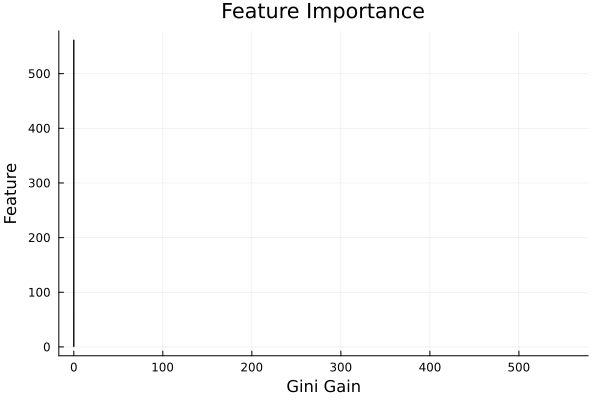

In [130]:
using MLJ
using Plots
using DecisionTree

# Extraer los parámetros de los modelos ajustados
fitted_model = fitted_params(machines["Random Forest"])

# Obtener importancia de características
importances = DecisionTree.impurity_importance(fitted_model.forest)

p = bar(
    1:length(importances),
    importances,
    orientation = :horizontal,
    legend = false
)
xlabel!(p, "Gini Gain")
ylabel!(p, "Feature")
title!(p, "Feature Importance")


In [132]:
using MLJ
using Plots
using DecisionTree

# Modelo ajustado
fitted_model = fitted_params(machines["Random Forest"])

# Importancia de características
importances = DecisionTree.impurity_importance(fitted_model.forest)

# Nombres de features
n_features = length(importances)
feature_names = ["x$i" for i in 1:n_features]  # si no tienes nombres reales

# Top 20
sorted_indices = sortperm(importances, rev=true)
top_n = min(20, n_features)
top_indices = sorted_indices[1:top_n]

top_importances = importances[top_indices]
top_features = feature_names[top_indices]

# Graficar
p = bar(
    top_importances,
    top_features,
    orientation = :h,
    legend = false
)
xlabel!(p, "Gini Gain")
ylabel!(p, "Feature")
title!(p, "Top $top_n Feature Importance")
display(p)


MethodError: MethodError: no method matching AbstractFloat(::Type{String})
The type `AbstractFloat` exists, but no method is defined for this combination of argument types when trying to construct it.

Closest candidates are:
  AbstractFloat(!Matched::Int16)
   @ Base float.jl:346
  AbstractFloat(!Matched::Bool)
   @ Base float.jl:344
  AbstractFloat(!Matched::UInt32)
   @ Base float.jl:352
  ...


In [91]:
using MLJ
using MLJBase: accuracy
using Plots
using DecisionTree

RandomForestClassifier = @load RandomForestClassifier pkg=DecisionTree verbosity=0

models = Dict()
machines = Dict()

models["Random Forest"] = RandomForestClassifier(n_trees=500, max_depth=10, rng=SEED)
machines["Random Forest"] = machine(models["Random Forest"], MLJ.table(X_train), y_train) |> fit!

for (name, machine) in machines
    y_pred = MLJ.predict(machine, MLJ.table(X_test))
    y_pred_labels = MLJ.mode.(y_pred)
    acc = accuracy(y_pred_labels, y_test)
    println("$name: $(acc*100) %")
end

# Feature importance
fitted_model = fitted_params(machines["Random Forest"])
importances = DecisionTree.impurity_importance(fitted_model.forest)

p = bar(importances, 1:length(importances), orientation=:horizontal, legend=false)
xlabel!("Gini Gain")
ylabel!("Feature")
yticks!(1:length(names(X_train)), names(X_train))
title!("Feature Importance")
display(p)


┌ Info: Training machine(RandomForestClassifier(max_depth = 10, …), …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


Random Forest: 87.38574040219378 %


MethodError: MethodError: no method matching names(::Matrix{Float64})
The function `names` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  names(!Matched::DataFrames.Index)
   @ DataFrames C:\Users\aniba\.julia\packages\DataFrames\b4w9K\src\other\index.jl:34
  names(!Matched::Module; all, imported)
   @ Base reflection.jl:94
  names(!Matched::GroupedDataFrame)
   @ DataFrames C:\Users\aniba\.julia\packages\DataFrames\b4w9K\src\groupeddataframe\groupeddataframe.jl:348
  ...


In [59]:
# 1. Extraer los parámetros ajustados
fitted_res = fitted_params(machines["Random Forest"])

# 2. En DecisionTree.jl, la importancia se calcula a partir del bosque
# Usamos la función impurity_importance o simplemente accedemos al campo si está disponible
# En MLJ para DecisionTree, se suele extraer así:
feature_importances = impurity_importance(fitted_res.forest)

# 3. Imprimir la importancia de las características
p = bar(
    1:length(feature_importances),
    feature_importances,
    orientation = :horizontal,
    legend = false,
    color = :skyblue
)
xlabel!(p, "Gini Gain (Importancia)")
ylabel!(p, "Índice de la Variable")
title!(p, "Importancia de Características - Random Forest")

# Mostrar solo las 20 más importantes si quieres que se vea mejor
# top_idx = sortperm(feature_importances, rev=true)[1:20]
# bar(top_idx, feature_importances[top_idx], orientation=:h)

UndefVarError: UndefVarError: `impurity_importance` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing DecisionTree in the current active module Main

In [60]:
using MLJ, MLJDecisionTreeInterface, StatsPlots

# Acceder al objeto forest
rf_forest = fitted_params(machines["Random Forest"]).forest

# Obtener la importancia de características usando la función del paquete DecisionTree
feature_importances = DecisionTree.feature_importances(rf_forest)

# Nombres de las variables
feature_names = names(X_train)

# Ordenar de mayor a menor
sorted_idx = sortperm(feature_importances, rev=true)
feature_names_sorted = feature_names[sorted_idx]
feature_importances_sorted = feature_importances[sorted_idx]

# Graficar
p = bar(
    feature_names_sorted,
    feature_importances_sorted,
    orientation = :vertical,
    legend = false,
    xlabel = "Features",
    ylabel = "Gini Gain",
    title = "Random Forest Feature Importance"
)
display(p)


ArgumentError: ArgumentError: Package StatsPlots not found in current path.
- Run `import Pkg; Pkg.add("StatsPlots")` to install the StatsPlots package.

# OTRAS PRUEBAS

Calculando proyecciones...


Computing t-SNE   2%|█                                   |  ETA: 0:00:05
Computing t-SNE   7%|███                                 |  ETA: 0:00:04
Computing t-SNE  10%|████                                |  ETA: 0:00:03
Computing t-SNE  14%|██████                              |  ETA: 0:00:03
Computing t-SNE  18%|███████                             |  ETA: 0:00:03
Computing t-SNE  22%|████████                            |  ETA: 0:00:03
Computing t-SNE  25%|█████████                           |  ETA: 0:00:03
Computing t-SNE  28%|███████████                         |  ETA: 0:00:02
Computing t-SNE  31%|████████████                        |  ETA: 0:00:02
Computing t-SNE  35%|█████████████                       |  ETA: 0:00:02
Computing t-SNE  39%|██████████████                      |  ETA: 0:00:02
Computing t-SNE  42%|████████████████                    |  ETA: 0:00:02
Computing t-SNE  46%|█████████████████                   |  ETA: 0:00:02
Computing t-SNE  50%|██████████████████            

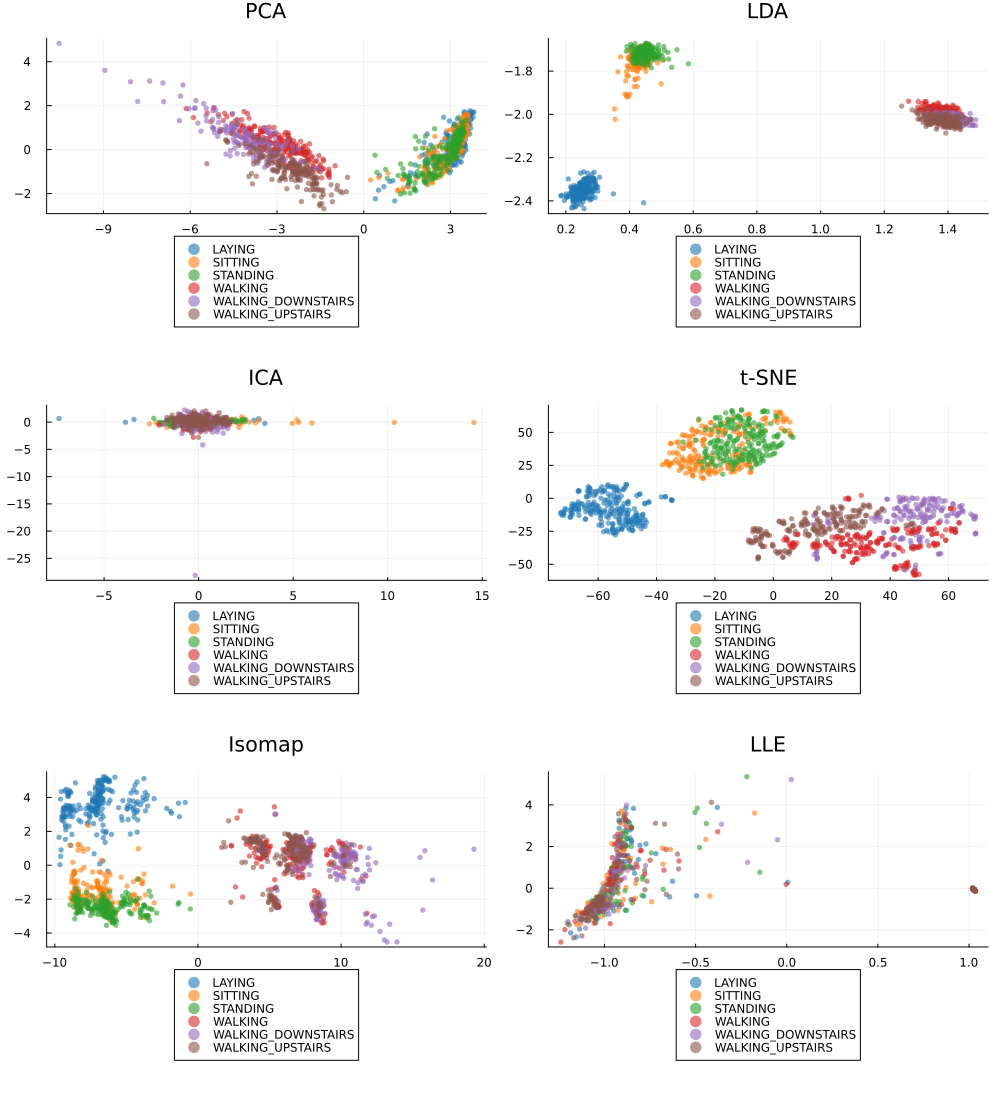

In [115]:
using Plots, TSne, ManifoldLearning, StatsBase

# 1. Muestreo y limpieza
Random.seed!(SEED)
n_samples = 1200 
sample_idx = sample(1:nrow(df_imputed), n_samples, replace=false)
X_sample = X_full[sample_idx, :]
y_sample = y_full[sample_idx]

# Normalización y eliminación de columnas constantes (para que ICA no explote)
mminmax = machine(MinMaxNormalizer(), MLJBase.table(X_sample))
fit!(mminmax, verbosity=0)
X_norm_mat = MLJBase.matrix(MLJBase.transform(mminmax, MLJBase.table(X_sample)))
X_clean = X_norm_mat[:, vec(var(X_norm_mat, dims=1) .> 1e-9)]
X_table = MLJBase.table(X_clean)

# Función de dibujo con corrección de etiquetas para Isomap/LLE
function plot_dim_reduction(X_2d, labels, title)
    if X_2d === nothing
        return plot(title=title * " (Falló)", grid=false, xaxis=false, yaxis=false)
    end
    # Si el algoritmo devuelve menos puntos (componente conexo), ajustamos etiquetas
    n_pts = size(X_2d, 1)
    scatter(X_2d[:,1], X_2d[:,2], group=labels[1:n_pts], 
            title=title, markersize=3, markerstrokewidth=0, 
            alpha=0.6, palette=:tab10, legend=:none)
end

println("Calculando proyecciones...")

# PCA (maxoutdim)
pca_m = machine(PCA_model(maxoutdim=2), X_table); fit!(pca_m, verbosity=0)
p1 = plot_dim_reduction(MLJBase.matrix(MLJBase.transform(pca_m, X_table)), y_sample, "PCA")

# LDA (outdim)
lda_m = machine(LDA_model(outdim=2), X_table, y_sample); fit!(lda_m, verbosity=0)
p2 = plot_dim_reduction(MLJBase.matrix(MLJBase.transform(lda_m, X_table)), y_sample, "LDA")

# ICA (Con reintento y tolerancia relajada)
ica_model = @load ICA pkg=MultivariateStats verbosity=0
X_ica = nothing
try
    ica_m = machine(ica_model(outdim=200, maxiter=500, tol=1e-1, do_whiten=true), X_table)
    fit!(ica_m, verbosity=0)
    X_ica = MLJBase.matrix(MLJBase.transform(ica_m, X_table))
catch; end
p3 = plot_dim_reduction(X_ica, y_sample, "ICA")

# t-SNE
p4 = plot_dim_reduction(tsne(X_clean, 2, 0, 1000, 30.0), y_sample, "t-SNE")

# Isomap y LLE (k=40 para evitar BoundsError por desconexión)
X_iso = nothing; try X_iso = ManifoldLearning.predict(ManifoldLearning.fit(Isomap, X_clean'; k=40, maxoutdim=2))' catch; end
p5 = plot_dim_reduction(X_iso, y_sample, "Isomap")

X_lle = nothing; try X_lle = ManifoldLearning.predict(ManifoldLearning.fit(LLE, X_clean'; k=40, maxoutdim=2))' catch; end
p6 = plot_dim_reduction(X_lle, y_sample, "LLE")

# Mostrar el mosaico final
plot(p1, p2, p3, p4, p5, p6, layout=(3,2), size=(1000, 1100), legend=:outerbottom)